In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

zadanie 1: znalezienie maksimum

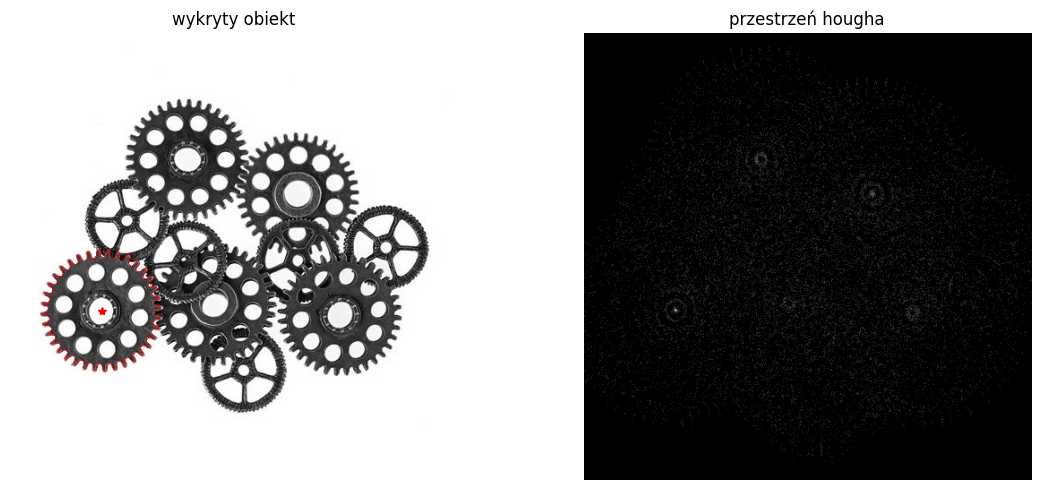

In [2]:
trybik = cv2.imread('trybik.jpg')
gray = cv2.cvtColor(trybik, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
binary = cv2.medianBlur(binary, 5)
binary = cv2.bitwise_not(binary)

# kontury
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# gradienty i orientacje
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    
# amplituda gradientu znormalizowana przez wartość max
amplitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
amplitude /= np.amax(amplitude)
# orientacja gradientu w stopniach
orientation = np.rad2deg(np.arctan2(sobel_y, sobel_x))
orientation = ((orientation + 360) % 360).astype(np.uint16)

# środek ciężkości
moments = cv2.moments(binary, binaryImage=True)
cx = int(moments['m10'] / moments['m00'])
cy = int(moments['m01'] / moments['m00'])

# R-table
r_table = [[] for _ in range(360)]
for point in contours[0]:
    x, y = point[0]
    angle = orientation[y, x]
    # wektor łączący kontury z punktem referencyjnym
    dx = x - cx
    dy = y - cy
    # długośc wektora
    r = np.sqrt(dx**2 + dy**2)
    # kąt z osią ox
    fi = np.arctan2(dy, dx)
    r_table[angle].append((r, fi))


trybiki2 = cv2.imread('trybiki2.jpg')
gray = cv2.cvtColor(trybiki2, cv2.COLOR_BGR2GRAY)
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)

amplitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
amplitude /= np.amax(amplitude)

orientation = np.rad2deg(np.arctan2(sobel_y, sobel_x))
orientation = ((orientation + 360) % 360).astype(np.uint16)

hough = np.zeros_like(gray, dtype=np.uint32)

for y in range(gray.shape[0]):
    for x in range(gray.shape[1]):
        if amplitude[y, x] > 0.5:
            angle = orientation[y, x]
            for r, fi in r_table[angle]:
                x1 = int(x - r * np.cos(fi))
                y1 = int(y - r * np.sin(fi))
                if 0 <= x1 < gray.shape[1] and 0 <= y1 < gray.shape[0]:
                    hough[y1, x1] += 1

max_y, max_x = np.unravel_index(np.argmax(hough), hough.shape)

img_with_contour = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
dx = max_x - cx
dy = max_y - cy
translated_contour = contours[0] + np.array([[dx, dy]])
cv2.drawContours(img_with_contour, [translated_contour], 0, (0, 0, 255))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("wykryty obiekt")
plt.imshow(cv2.cvtColor(img_with_contour, cv2.COLOR_BGR2RGB))
plt.plot([max_x], [max_y], '*', color='red')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("przestrzeń hougha")
plt.imshow(np.log(hough + 1), 'gray')
plt.axis('off')

plt.tight_layout()
plt.show()